In [1]:
from math import exp, pow, sqrt
import numpy as np
from tifffile import imwrite
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

We assume values are given in cm

In [2]:
source_position = np.asarray([0, 0, -10])
detector_position = np.asarray([0, 0, 5])
sphere_centre = np.asarray([0, 0, 0])
sphere_radius = 1.25
mu = 0.5 # linear attenuation coefficient in cm^-1

image_resolution = [400, 400]
pixel_pitch = 0.0125

N = 15000 # Number of incident photons

path_length_buffer = np.zeros([image_resolution[1], image_resolution[0]], dtype=np.single)
xray_image = np.zeros([image_resolution[1], image_resolution[0]], dtype=np.single)

Function to compute the intersections between a ray and a sphere

In [3]:
def ray_instersection_sphere(ray_origin, ray_direction, sphere_centre, sphere_radius):

    # Uncomment for a parallel beam
    # ray_direction = np.array([0, 0, 1])

    oc = ray_origin - sphere_centre
    a = np.dot(ray_direction, ray_direction)
    b = 2.0 * np.dot(oc, ray_direction)
    c = np.dot(oc, oc) - pow(sphere_radius, 2)

    determinant = b * b - 4 * a * c

    if determinant < 0:
        return None, None
    else:
        t1 = (-b - sqrt(determinant)) / (2.0 * a)
        t2 = (-b + sqrt(determinant)) / (2.0 * a)
        return min(t1, t2), max(t1, t2)

Process every pixel of the image

In [4]:
half_width = pixel_pitch * (image_resolution[0] - 1) / 2
half_height = pixel_pitch * (image_resolution[1] - 1) / 2

for j in range(image_resolution[1]):
    for i in range(image_resolution[0]):
        pixel_location = np.asarray([
            detector_position[0] - half_width + i * pixel_pitch,
            detector_position[1] - half_height + j * pixel_pitch,
            detector_position[2]
        ])

        ray_direction = pixel_location - source_position
        ray_direction /= np.linalg.norm(ray_direction)

        t1, t2 = ray_instersection_sphere(source_position, ray_direction, sphere_centre, sphere_radius)

        if t1 is not None and t2 is not None:
            x = abs(t1 - t2)
            path_length_buffer[j,i] += x
            xray_image[j,i] = N * exp(-mu * x)

Display the results

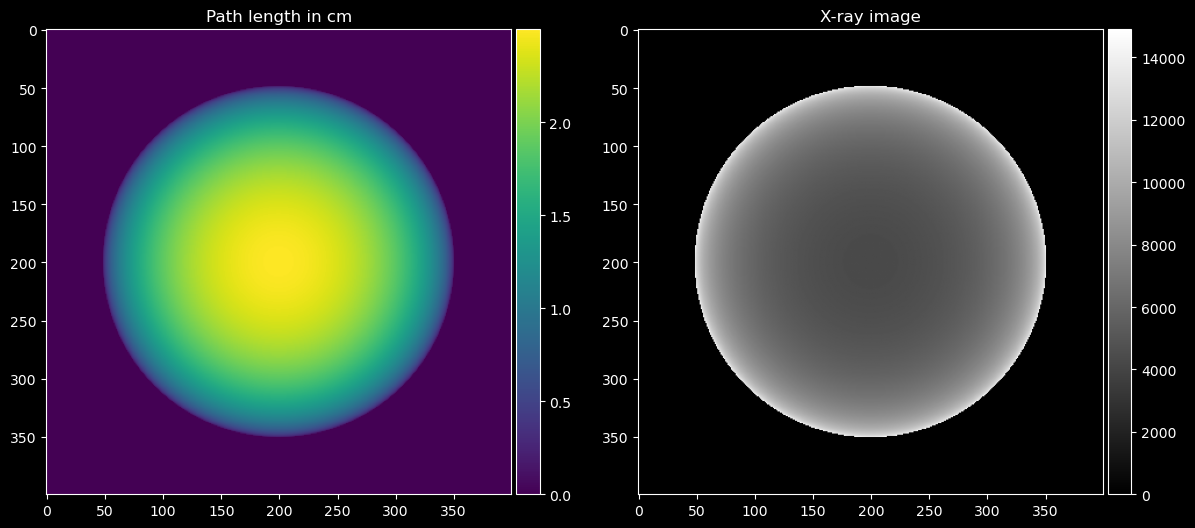

In [5]:
fig = plt.figure(figsize=(14, 12))

ax0 = fig.add_subplot(121)
ax0.set_title("Path length in cm")
im0 = ax0.imshow(path_length_buffer)
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')

ax1 = fig.add_subplot(122)
ax1.set_title("X-ray image")
im1 = ax1.imshow(xray_image, cmap='gray')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

plt.show()

Save the images

In [6]:
imwrite("path_length_in_cm.tif", path_length_buffer)
imwrite("xray_image.tif", xray_image)